In [1]:
from arcgis.gis import GIS
from arcgis.features import FeatureLayer
gis = GIS("https://ourcommunity.maps.arcgis.com", "MMajumdar_ourcommunity")

Enter password: ········


We read in the twitter data scraped and stored in a FeatureLayer. [Here](https://github.com/Jwmazzi/twitter_agol) is the Github repository for the script that scrapes this data

In [2]:
tweets_item = gis.content.get('e441d3f5e13b412299418034d1fb0eba')
tweets_layer = FeatureLayer(tweets_item.url+'/0')
tweets_features = tweets_layer.query(out_fields='tweet_text, hashtags, screen_name, state, party, created_at')
tweets_df = tweets_features.sdf
tweets_df.shape

(16954, 7)

In [3]:
tweets_df.head()

,ObjectId,tweet_text,hashtags,screen_name,state,party,created_at
0,1261651,I don’t understand how can I go from that to T...,,meganewifey,Michigan,Other,2020-10-31 07:05:41
1,1261652,Hope voters of Bihar will not trapped under d...,,bpratap62071421,Michigan,Other,2020-10-31 07:05:41
2,1261653,@arsenal_N1 @htTweets No I havent read it. Its...,,utterflea,Michigan,Other,2020-10-31 07:05:41
3,1261654,Officials seized 151.82 grams of gold from the...,,ExpressPune,Michigan,Other,2020-10-31 07:05:41
4,1261655,@NBA2K_MyTEAM So people really stayed up for t...,,Calcooler26,Michigan,Other,2020-10-31 07:05:40


We now convert potential state abbreviations in the `state` field to state name in the following function

In [4]:
us_state_abbrev = {'AL':'Alabama',
    'AK':'Alaska',
    'AZ':'Arizona',
    'AR':'Arkansas',
    'CA':'California',
    'CO':'Colorado',
    'CT':'Connecticut',
    'DE':'Delaware',
    'DC':'District of Columbia',
    'FL':'Florida',
    'GA':'Georgia',
    'HI':'Hawaii',
    'ID':'Idaho',
    'IL':'Illinois',
    'IN':'Indiana',
    'IA':'Iowa',
    'KS':'Kansas',
    'KY':'Kentucky',
    'LA':'Louisiana',
    'ME':'Maine',
    'MD':'Maryland',
    'MA':'Massachusetts',
    'MI':'Michigan',
    'MN':'Minnesota',
    'MS':'Mississippi',
    'MO':'Missouri',
    'MT':'Montana',
    'NE':'Nebraska',
    'NV':'Nevada',
    'NH':'New Hampshire',
    'NJ':'New Jersey',
    'NM':'New Mexico',
    'NY':'New York',
    'NC':'North Carolina',
    'ND':'North Dakota',
    'OH':'Ohio',
    'OK':'Oklahoma',
    'OR':'Oregon',
    'PA':'Pennsylvania',
    'RI':'Rhode Island',
    'SC':'South Carolina',
    'SD':'South Dakota',
    'TN':'Tennessee',
    'TX':'Texas',
    'UT':'Utah',
    'VT':'Vermont',
    'VA':'Virginia',
    'WA':'Washington',
    'WV':'West Virginia',
    'WI':'Wisconsin',
    'WY':'Wyoming'
}

In [5]:
def replace_states(value):
    '''Replace state abbreviations with state names'''
    if len(value)==2:
        return us_state_abbrev[value]
    else:
        return value

In [6]:
tweets_df['state'] = tweets_df['state'].apply(replace_states)
tweets_df.head()

,ObjectId,tweet_text,hashtags,screen_name,state,party,created_at
0,1261651,I don’t understand how can I go from that to T...,,meganewifey,Michigan,Other,2020-10-31 07:05:41
1,1261652,Hope voters of Bihar will not trapped under d...,,bpratap62071421,Michigan,Other,2020-10-31 07:05:41
2,1261653,@arsenal_N1 @htTweets No I havent read it. Its...,,utterflea,Michigan,Other,2020-10-31 07:05:41
3,1261654,Officials seized 151.82 grams of gold from the...,,ExpressPune,Michigan,Other,2020-10-31 07:05:41
4,1261655,@NBA2K_MyTEAM So people really stayed up for t...,,Calcooler26,Michigan,Other,2020-10-31 07:05:40


## 1. Extracting mentions and sentiments for tweets

We extract the mentions (people/entities tagged) in each tweet

In [7]:
tweets_df['mention'] = tweets_df['tweet_text'].str.findall(r'(?<![@\w])@(\w{1,25})').apply(','.join)
tweets_df['mention'].head()

0                       
1                       
2    arsenal_N1,htTweets
3                       
4           NBA2K_MyTEAM
Name: mention, dtype: object

Using `vaderSentiment` library we now extract the sentiment score for each tweet

In [8]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [9]:
def sentiment_analyzer(tweet):
    '''Return the dictionary of scores for each sentiment'''
    return analyser.polarity_scores(tweet)

In [10]:
def sentiment_score(dict1):
    '''Return the average sentiment for the tweet'''
    return dict1['compound']

In [11]:
tweets_df['sentiment_dict'] = tweets_df['tweet_text'].apply(sentiment_analyzer)
tweets_df['sentiment_score'] = tweets_df['sentiment_dict'].apply(sentiment_score)
tweets_df.head()

,ObjectId,tweet_text,hashtags,screen_name,state,party,created_at,mention,sentiment_dict,sentiment_score
0,1261651,I don’t understand how can I go from that to T...,,meganewifey,Michigan,Other,2020-10-31 07:05:41,,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
1,1261652,Hope voters of Bihar will not trapped under d...,,bpratap62071421,Michigan,Other,2020-10-31 07:05:41,,"{'neg': 0.029, 'neu': 0.761, 'pos': 0.21, 'com...",0.8191
2,1261653,@arsenal_N1 @htTweets No I havent read it. Its...,,utterflea,Michigan,Other,2020-10-31 07:05:41,"arsenal_N1,htTweets","{'neg': 0.063, 'neu': 0.86, 'pos': 0.077, 'com...",0.1280
3,1261654,Officials seized 151.82 grams of gold from the...,,ExpressPune,Michigan,Other,2020-10-31 07:05:41,,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
4,1261655,@NBA2K_MyTEAM So people really stayed up for t...,,Calcooler26,Michigan,Other,2020-10-31 07:05:40,NBA2K_MyTEAM,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000


In [12]:
import matplotlib.pyplot as plt 
import seaborn as sns

#set preferences
sns.set(color_codes=True)

Having extracted sentiments for each tweet, we now visualize the general sentiment distribution

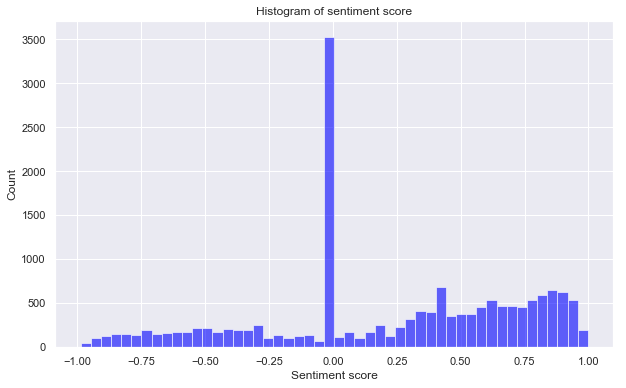

In [13]:
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(tweets_df['sentiment_score'], num_bins, facecolor='blue', alpha=0.6)
plt.xlabel('Sentiment score')
plt.ylabel('Count')
plt.title('Histogram of sentiment score')
plt.show();

## 2. Extract tokens for each tweet

In [14]:
from nltk.tokenize import word_tokenize
import pandas as pd

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\manu9321\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
tweets_df['tokens'] = tweets_df['tweet_text'].apply(word_tokenize)
tweets_df['tokens'].head()

0    [I, don, ’, t, understand, how, can, I, go, fr...
1    [Hope, voters, of, Bihar, will, not, trapped, ...
2    [@, arsenal_N1, @, htTweets, No, I, havent, re...
3    [Officials, seized, 151.82, grams, of, gold, f...
4    [@, NBA2K_MyTEAM, So, people, really, stayed, ...
Name: tokens, dtype: object

In [16]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\manu9321\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
from nltk.corpus import stopwords
english_stopwords = set(stopwords.words('english'))

We write a method to remove stopwords (e.g. 'this', 'a', 'to') etc from our tokens. We also add a few others, specific to our data

In [18]:
def clean_tokens(tokens):
    '''Remove punctuation and stopwords from tokens'''
    english_stopwords.add('http')
    english_stopwords.add('https')
    english_stopwords.add('amp')
    tokens1 = [word for word in tokens if word.isalnum()]
    return [x for x in tokens1 if x.lower() not in english_stopwords]

In [19]:
tweets_df['cleaned_tokens'] = tweets_df['tokens'].apply(clean_tokens)
tweets_df['cleaned_tokens'].head()

0                                     [understand, go]
1    [Hope, voters, Bihar, trapped, different, tric...
2    [htTweets, havent, read, released, point, colu...
3    [Officials, seized, grams, gold, two, bags, pa...
4                         [people, really, stayed, 2k]
Name: cleaned_tokens, dtype: object

In [20]:
tweets_df.head()

,ObjectId,tweet_text,hashtags,screen_name,state,party,created_at,mention,sentiment_dict,sentiment_score,tokens,cleaned_tokens
0,1261651,I don’t understand how can I go from that to T...,,meganewifey,Michigan,Other,2020-10-31 07:05:41,,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,"[I, don, ’, t, understand, how, can, I, go, fr...","[understand, go]"
1,1261652,Hope voters of Bihar will not trapped under d...,,bpratap62071421,Michigan,Other,2020-10-31 07:05:41,,"{'neg': 0.029, 'neu': 0.761, 'pos': 0.21, 'com...",0.8191,"[Hope, voters, of, Bihar, will, not, trapped, ...","[Hope, voters, Bihar, trapped, different, tric..."
2,1261653,@arsenal_N1 @htTweets No I havent read it. Its...,,utterflea,Michigan,Other,2020-10-31 07:05:41,"arsenal_N1,htTweets","{'neg': 0.063, 'neu': 0.86, 'pos': 0.077, 'com...",0.1280,"[@, arsenal_N1, @, htTweets, No, I, havent, re...","[htTweets, havent, read, released, point, colu..."
3,1261654,Officials seized 151.82 grams of gold from the...,,ExpressPune,Michigan,Other,2020-10-31 07:05:41,,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,"[Officials, seized, 151.82, grams, of, gold, f...","[Officials, seized, grams, gold, two, bags, pa..."
4,1261655,@NBA2K_MyTEAM So people really stayed up for t...,,Calcooler26,Michigan,Other,2020-10-31 07:05:40,NBA2K_MyTEAM,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,"[@, NBA2K_MyTEAM, So, people, really, stayed, ...","[people, really, stayed, 2k]"


## 3. Compute stats for each state

In [25]:
states_url = 'https://services1.arcgis.com/99lidPhWCzftIe9K/arcgis/rest/services/USStates/FeatureServer/0'
states_layer = FeatureLayer(states_url)
states_df = states_layer.query().sdf
states_df.shape

(51, 8)

In [26]:
states_df.head()

,OBJECTID_1,OBJECTID,STATE_NAME,STATE_FIPS,STATE_ABBR,Shape__Area,Shape__Length,SHAPE
0,1,None,Alabama,01,AL,1.899684e+11,2.506745e+06,"{""rings"": [[[-9848795.1956, 3749386.4234], [-9..."
1,2,None,Alaska,02,AK,4.864666e+12,4.827816e+07,"{""rings"": [[[-16280479.1337, 11068714.8191], [..."
2,3,None,Arizona,04,AZ,4.341107e+11,2.907332e+06,"{""rings"": [[[-12781025.0556, 3828631.1485], [-..."
3,4,None,Arkansas,05,AR,2.053290e+11,2.652242e+06,"{""rings"": [[[-10531500.4946, 4369567.5414], [-..."
4,5,None,California,06,CA,6.496358e+11,6.856510e+06,"{""rings"": [[[-13829195.0781, 4967239.458], [-1..."


In [27]:
filtered_tweets = tweets_df[['state', 'party', 'mention', 'hashtags', 'sentiment_score', 'cleaned_tokens']]
filtered_tweets.head()

,state,party,mention,hashtags,sentiment_score,cleaned_tokens
0,Michigan,Other,,,0.0000,"[understand, go]"
1,Michigan,Other,,,0.8191,"[Hope, voters, Bihar, trapped, different, tric..."
2,Michigan,Other,"arsenal_N1,htTweets",,0.1280,"[htTweets, havent, read, released, point, colu..."
3,Michigan,Other,,,0.0000,"[Officials, seized, grams, gold, two, bags, pa..."
4,Michigan,Other,NBA2K_MyTEAM,,0.0000,"[people, really, stayed, 2k]"


In [28]:
filtered_tweets = pd.get_dummies(filtered_tweets, columns=['party'], prefix=['party'])
filtered_tweets.head()

,state,mention,hashtags,sentiment_score,cleaned_tokens,party_D,party_I,party_Other,party_R
0,Michigan,,,0.0000,"[understand, go]",0,0,1,0
1,Michigan,,,0.8191,"[Hope, voters, Bihar, trapped, different, tric...",0,0,1,0
2,Michigan,"arsenal_N1,htTweets",,0.1280,"[htTweets, havent, read, released, point, colu...",0,0,1,0
3,Michigan,,,0.0000,"[Officials, seized, grams, gold, two, bags, pa...",0,0,1,0
4,Michigan,NBA2K_MyTEAM,,0.0000,"[people, really, stayed, 2k]",0,0,1,0


In [29]:
state_group = filtered_tweets.groupby('state').agg({'party_D':'sum', 'party_R':'sum', 'party_I':'sum', 'party_Other':'sum', 'sentiment_score':'median', 'mention': ' '.join, 'hashtags': ' '.join, 'cleaned_tokens': 'sum'})

## 4. Find most frequently occuring mention and hashtag for each state

We write a method that can be used to extract the mention and hashtag used more frequently for each state

In [30]:
from collections import Counter

In [31]:
def most_frequent_word(sequence):
    '''Extract the most freqently occuring word from a sequence (string) of words'''
    try:
        tokens = word_tokenize(sequence)
        tokens = [word for word in tokens if word.isalnum()]
        occurence_count = Counter(tokens) 
        return occurence_count.most_common(1)[0][0]
    except:
        return ''

In [32]:
state_group['freq_mention'] = state_group['mention'].apply(most_frequent_word)
state_group['freq_hashtag'] = state_group['hashtags'].apply(most_frequent_word)

In [33]:
state_group.head()

,party_D,party_R,party_I,party_Other,sentiment_score,mention,hashtags,cleaned_tokens,freq_mention,freq_hashtag
state,,,,,,,,,,
Alabama,99.0,42.0,0,0.0,0.31820,"RepMoBrooks,TTuberville,RepBarryMoore ASCPhar...","al01, alpolitics al01 al01 alpolitics, ...","[two, things, must, happen, polls, close, Amer...",TTuberville,al01
Arizona,259.0,166.0,0,0.0,0.31820,"SheRa_Resists,RepGosar,realDonaldTrump,RepGosa...","Narcissistic, AZ04 AZ04 AZ04, Arizona A...","[RepGosar, realDonaldTrump, know, RepGosar, bl...",realDonaldTrump,AZ01
Arkansas,63.0,48.0,0,0.0,0.55740,"will_watson NicoleFauteux1,BGlickstein,delina...","bellavistaarkansas, election2020, electi...","[NicoleFauteux1, BGlickstein, delina4az, Freel...",RonettaForAR1,ElectANurse
California,808.0,532.0,0,0.0,0.27320,"IKhoR_Slayz knittwittier,vermontgmg WallStXy...",...,"[part, knittwittier, vermontgmg, Yes, saying, ...",realDonaldTrump,CA53
Colorado,104.0,77.0,8,7.0,0.19935,"pweiser,JenaGris...",VOTE VOTE ...,"[Thank, everyone, donated, volunteered, voted,...",realDonaldTrump,copolitics


## 5. Extract the 5 most frequently used words/topics for each state

First we lemmatize each word, i.e extract the root for each word to equalize them. E.g. Running, ran, runner will all be reduced to the root word _run_

In [34]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\manu9321\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [35]:
from nltk.corpus import wordnet as wn

In [36]:
def get_lemma(word):
    '''Return root of each word'''
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

def lemmatize_tokens(tokens):
    '''Return cleaned tokens in their root form'''
    return [get_lemma(token).lower() for token in tokens]

In [37]:
state_group['token_root_words'] = state_group['cleaned_tokens'].apply(lemmatize_tokens)

We now use these lemmatized tokens to extract the 10 most frequent words/topics with frequency of each

In [38]:
from nltk.probability import FreqDist

In [39]:
def frequent_words_for_state(token_roots):
    '''Return the 10 most frequent words in tweets for each state'''
    return FreqDist(token_roots).most_common(10)

In [40]:
state_group['freq_10_words'] = state_group['token_root_words'].apply(frequent_words_for_state)
state_group.head()

,party_D,party_R,party_I,party_Other,sentiment_score,mention,hashtags,cleaned_tokens,freq_mention,freq_hashtag,token_root_words,freq_10_words
state,,,,,,,,,,,,
Alabama,99.0,42.0,0,0.0,0.31820,"RepMoBrooks,TTuberville,RepBarryMoore ASCPhar...","al01, alpolitics al01 al01 alpolitics, ...","[two, things, must, happen, polls, close, Amer...",TTuberville,al01,"[two, things, must, happen, polls, close, amer...","[(vote, 29), (thank, 20), (election, 15), (tod..."
Arizona,259.0,166.0,0,0.0,0.31820,"SheRa_Resists,RepGosar,realDonaldTrump,RepGosa...","Narcissistic, AZ04 AZ04 AZ04, Arizona A...","[RepGosar, realDonaldTrump, know, RepGosar, bl...",realDonaldTrump,AZ01,"[repgosar, realdonaldtrump, know, repgosar, bl...","[(vote, 136), (election, 61), (thank, 50), (ba..."
Arkansas,63.0,48.0,0,0.0,0.55740,"will_watson NicoleFauteux1,BGlickstein,delina...","bellavistaarkansas, election2020, electi...","[NicoleFauteux1, BGlickstein, delina4az, Freel...",RonettaForAR1,ElectANurse,"[nicolefauteux1, bglickstein, delina4az, freel...","[(vote, 42), (us, 20), (voting, 20), (voter, 1..."
California,808.0,532.0,0,0.0,0.27320,"IKhoR_Slayz knittwittier,vermontgmg WallStXy...",...,"[part, knittwittier, vermontgmg, Yes, saying, ...",realDonaldTrump,CA53,"[part, knittwittier, vermontgmg, yes, saying, ...","[(vote, 526), (election, 219), (ballot, 152), ..."
Colorado,104.0,77.0,8,7.0,0.19935,"pweiser,JenaGris...",VOTE VOTE ...,"[Thank, everyone, donated, volunteered, voted,...",realDonaldTrump,copolitics,"[thank, everyone, donate, volunteer, vote, hop...","[(vote, 79), (election, 66), (ballot, 48), (dr..."


In [41]:
states_twitter = states_df.merge(right=state_group, left_on='STATE_NAME', right_on='state')
states_twitter.shape

(39, 20)

In [42]:
def split_freq_words(list1):
    result = ''
    for item in list1:
        result = result + item[0] + ', '
    return result

In [43]:
states_twitter['freq_words'] = states_twitter['freq_10_words'].apply(split_freq_words)

In [44]:
states_twitter['freq_words'].head()

0    vote, thank, election, today, let, us, make, s...
1    vote, election, thank, ballot, arizona, count,...
2    vote, us, voting, voter, electanurse, today, d...
3    vote, election, ballot, make, day, today, peop...
4    vote, election, ballot, drop, line, day, sure,...
Name: freq_words, dtype: object

In [45]:
states_twitter_data = states_twitter[['STATE_FIPS',
       'STATE_NAME', 'party_D', 'party_R', 'party_I', 'party_Other',
       'sentiment_score', 'freq_mention', 'freq_hashtag', 'freq_words']]

In [46]:
states_twitter_data.to_csv('tweets_analyzed.csv')